<a href="https://colab.research.google.com/github/leunco/Hands_On_MachineLearning/blob/main/6%EC%A3%BC%EC%B0%A8/%EA%B9%80%EB%8B%A4%EC%98%81/Chap12_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_%EC%82%AC%EC%9A%A9%EC%9E%90%EC%A0%95%EC%9D%98%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

## Chap12. 텐서플로를 사용한 사용자 정의 모델과 훈련
이 장에서는 텐서플로를 자세히 들여다보고 저수준 파이썬 API를 살펴본다.  

자신만의 손실 함수, 지표, 층, 모델, 초기화, 규제, 가중치 규제 등을 만들어 세부적으로 제어하는 방법을 학습한다.

그래디언트에 특별한 변환이나 규제를 적용하거나 네트워크의 부분마다 다른 옵티마이저를 사용하는 등 훈련 반복문 자체를 완전히 제어하는 방법을 학습한다.

또한 텐서플로의 자동 그래프 생성 기능을 사용하여 사용자 정의 모델과 훈련 알고리즘의 성능을 향상시키는 방법을 학습한다.



## 12.1 텐서플로 훑어보기
텐서플로는 **강력한 수치 계산용 라이브러리**로, 특히 대규모 머신러닝에 잘 맞도록 튜닝되었다.

셀 수 없이 많은 프로젝트가 텐서플로를 사용하여 이미지 분류, 자연어 처리, 추천 시스템, 시계열 예측 등과 같은 모든 종류의 머신러닝 작업을 수행한다.

텐서플로가 제공하는 것들을 간단하게 요약하면 다음과 같다.
- 핵심 구조는 넘파이와 매우 비슷하지만, GPU를 지원한다.
- 여러 장치와 서버에 대해서 분산 컴퓨팅을 지원한다.
- 일종의 JIT(Just-In-Time) 컴파일러를 포함한다. 속도를 높이고 메모리 사용량을 줄이기 위해 계산을 최적화한다. 이를 위해 파이썬 함수에서 계산 그래프를 추출한 다음 최적화하고 효율적으로 실행한다.
- 계산 그래프는 플랫폼에 중립적인 포맷으로 내보낼 수 있으므로 하나의 환경에서 텐서플로 모델을 훈련하고 다른 환경에서 실행할 수 있다.
- 텐서플로는 자동 미분 기능과 RMSProp, Nadam 같은 고성능 옵티마이저를 제공하므로 모든 종류의 손실 함수를 쉽게 최소화할 수 있다.

텐서플로에서 가장 중요한 것은 **`tf.keras`**이다.

**데이터 적재와 전처리 연산**(**`tf.data, tf.io`** 등), **이미지 처리 연산**(**`tf.image`**), **신호 처리 연산**(**`tf.signal`**)과 그 외 많은 기능을 가지고 있다.

아래의 그림은 텐서플로의 전체 파이썬 API를 요약한 것이다.

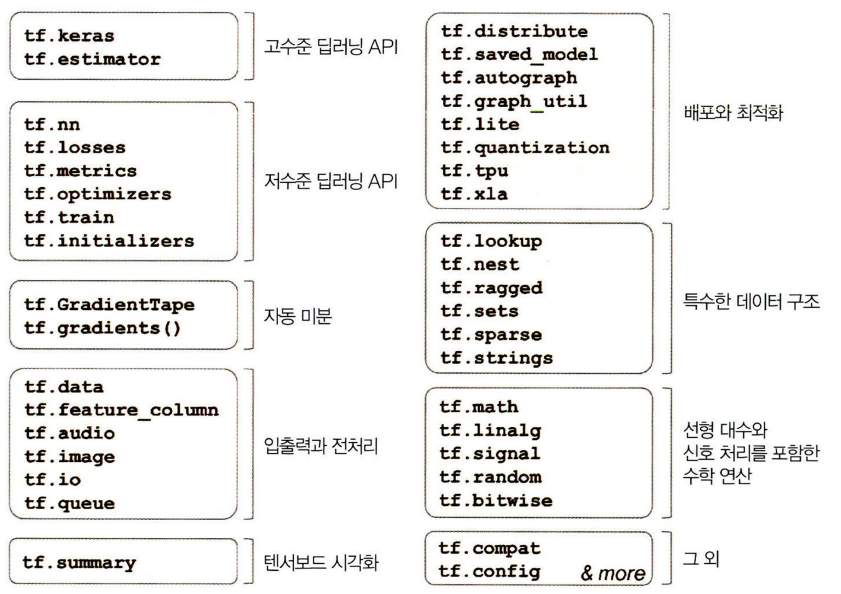

아래의 그림은 텐서플로 구조를 나타낸 것이다.

가장 저수준의 텐서플로 연산은 매우 효율적인 C++ 코드로 구현되어 있다.

많은 연산은 **커널**이라고 부르는 여러가지 구현을 갖는다. 각 커널은 CPU, GPU, TPU와 같은 특정 장치에 맞추어서 만들어졌다.
- GPU는 계산을 작은 단위로 나누어서 여러 GPU 스레드에서 병렬로 실행하므로 속도를 극적으로 향상시킨다.
- TPU는 딥러닝 연산을 위해 특별하게 설계된 ASIC 칩으로, 속도가 GPU보다 더 빠르다.

**대부분의 코드는 고수준 API**를 사용한다. 그러나 더 높은 자유도가 필요한 경우에는 저수준 파이썬 API를 사용하여 텐서를 직접 다루게 됩니다.

텐서플로의 실행 엔진은 여러 디바이스와 서버로 이루어진 분산 환경에서도 효율적으로 연산을 실행한다.

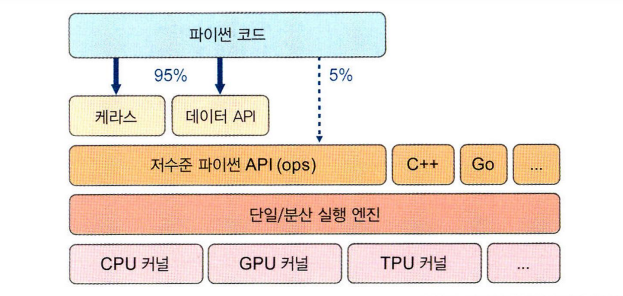

텐서플로는 하나의 라이브러리 그 이상으로, 광범위한 라이브러리 생태계를 가지고 있다.

먼저 **시각화**를 위한 **텐서보드**가 있다.

**텐서플로 제품화**를 위한 라이브러리 모음인 **TFX**가 있다. 여기에는 데이터 시각화, 전처리, 모델 분석, 서빙 등이 포함된다.

구글의 **텐서플로 허브**를 사용하면 **사전훈련된 신경망을 손쉽게 다운로드하여 재사용**할 수 있다.

## 12.2 넘파이처럼 텐서플로 사용하기
**텐서플로** API는 **텐서를 순환**시킨다. **텐서는 하나의 연산에서 다른 연산으로 흐른다.** 이러한 이유로 텐서플로라고 부른다.

텐서는 **넘파이 ndarray와 매우 비슷**하다. 즉 텐서는 일반적으로 **다차원 배열**이지만, **스칼라 값**을 가질 수도 있다.

사용자 정의 손실 함수, 사용자 정의 지표, 사용자 정의 층 등을 만들 때 텐서가 중요하다.

### 12.2.1 텐서와 연산
**`tf.constant()`** 함수를 사용하여 **텐서를 만들 수 있다.** 원하는 행렬이나 숫자 값을 입력하면 된다.

예를 들어 아래의 코드는 2개의 행과 3개의 열을 가진 실수 행렬을 나타내는 텐서이다.

ndarray와 마찬가지로 `tf.Tensor`는 **크기와 데이터 타입**을 가지며, **`shape`과 `dtype`**을 이용하여 확인할 수 있다.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # 행렬

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
tf.constant(42) # 스칼라

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

TensorShape([2, 3])

In [ ]:
t.dtype

tf.float32

또한 **인덱스 참조**도 넘파이와 매우 비슷하게 작동한다.

In [ ]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

가장 중요한 것은 **모든 종류의 텐서 연산이 가능**하다는 것이다.

`t+10`은 `tf.add(t,10)`을 호출하는 것과 동일하다. 뺄셈의 -와 곱셈의 *같은 다른 연산도 지원한다. @은 행렬 곱셈으로 `tf.matmul()` 함수를 호출하는 것과 동일하다.


In [ ]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [ ]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [ ]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

이외에도 `tf.add(), tf.multiply(), tf.square(), tf.exp(), tf.sqrt()` 등 **필요한 모든 기본 수학 연산을 제공**한다.

또한 `tf.reshape(), tf.squeeze(), tf.tile()` 등 **넘파이에서 볼 수 있는 대부분의 연산을 제공**한다. 일부 함수들은 넘파이와 다른 이름으로 표현된다. 예를 들어 `tf.reduce_mean()<->np.mean(), tf.reduce_sum()<->np.sum(), tf.reduce_max()<->np.max(), tf.math.log()<->np.log()` 이다.

예를 들어 텐서플로에서는 `tf.transpose(t)`라고 써야하며, 넘파이처럼 `t.T`라고 쓰면 안된다. 이름이 다른 이유는 `tf.transpose()` 함수가 넘파이의 `T` 속성과 완전히 동일한 작업을 수행하지 않기 때문이다. 텐서플로에서는 전치된 데이터의 복사본으로 새로운 텐서가 만들어지지만, 넘파이에서는 동일한 데이터의 전치된 뷰(view)일 뿐이다.

비슷하게 `tf.reduce_sum()` 연산인 이유도 이 GPU 커널이 원소가 추가된 순서를 보장하지 않는 reduce 알고리즘을 사용하기 때문이다.

**많은 함수와 클래스들이 별칭**을 가지고 있으므로, 별칭을 사용하여 패키지를 잘 조직화하여 자주 사용하는 연산의 이름을 간소화할 수 있다.

### 12.2.2 텐서와 넘파이
텐서로 넘파이 배열을 만들 수 있으며, 반대로 넘파이 배열로 텐서를 만들 수도 있다. 또한 텐서에 넘파이 연산을 적용할 수 있고, 넘파이 배열에 텐서플로 연산을 적용할 수도 있다. 따라서 텐서는 넘파이와 함께 사용하기 편리하다.

**넘파이**는 기본으로 **64비트** 정밀도를 사용하지만 **텐서플로**는 **32비트** 정밀도를 사용한다. 일반적으로 **신경망은 32비트 정밀도로 충분**하고, 더 빠르고 메모리도 적게 사용한다.

In [ ]:
import numpy as np
a = np.array([2, 4, 5])
a

array([2, 4, 5])

In [ ]:
tf.constant(a) # 넘파이 배열을 텐서로

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 4, 5])>

In [ ]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 4, 16, 25])>

In [ ]:
t.numpy() # 텐서를 넘파이 배열로

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 12.2.3 타입 변환
타입 변환은 성능을 크게 감소시킬 수 있으며, 자동으로 변환될 경우 사용자가 눈치채지 못할 수도 있다. 이를 방지하기 위해서 **텐서플로는 어떤 타입 변환도 자동으로 수행하지 않는다.** 따라서 호환되지 않는 텐서로 연산을 실행하면 예외가 발생한다.

예를 들어 실수 텐서와 정수 텐서를 더할 수 없으며, 같은 실수끼리도 비트가 다르다면 더할 수 없다.

진짜로 **타입 변환이 필요**할 때는 **`tf.cast()`** 함수를 사용할 수 있다.

In [ ]:
tf.constant(2.0) + tf.constant(40) # 오류

In [ ]:
tf.constant(2.0) + tf.constant(40., dtype=tf.float64) # 오류

In [ ]:
tf.constant(2.0).dtype

In [ ]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

### 12.2.4 변수
지금까지 본 **`tf.Tensor`는 변경이 불가능한 객체**로, 즉 **텐서의 내용을 바꿀 수 없다.**

따라서 일반적인 텐서로는 **역전파로 변경되어야 하는 신경망의 가중치**를 구현할 수 없다. 또한 **시간에 따라 변경되어야 할 다른 파라미터**도 존재하며, 이것이 **`tf.Variable`**이 필요한 이유이다.

In [ ]:
v = tf.Variable([[1.,2.,3.], [4.,5.,6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

`tf.Variable`은 **`tf.Tensor`와 비슷**하게 동작하여, **동일한 연산**을 수행할 수 있고 **넘파이와도 잘 호환**된다.

차이점은 **`assign()`** 메서드를 사용하여 **변수값을 바꿀 수 있다**는 것이다. **`assign_add()`** 메서드를 사용하여 주어진 값만큼 **변수를 증가**시킬 수 있으며, **`assign_sub()**` 메서드를 사용하여 주어진 값만큼 **변수를 감소**시킬 수 있다.

또한 **`assign(), scatter_update(), scatter_nd_update()`** 메서드를 사용하여 **개별 원소 또는 슬라이스를 수정**할 수도 있다. `scatter_nd_update()`는 `indices`에 바꾸고 싶은 슬라이스의 인덱스를, `updates`에 바꾸고 싶은 값을 지정한다.

In [ ]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[0,1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[:,2].assign([0.,1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [ ]:
v.scatter_nd_update(indices=[[0,0],[1,2]], updates=[100.,200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

### 12.2.5 다른 데이터 구조
텐서플로는 다음과 같은 몇 가지의 다른 데이터 구조도 지원한다.


#### 희소 텐서 (`tf.SparseTensor`)
대부분 0으로 채워진 텐서를 효율적으로 나타낸다.

**`tf.sparse`** 패키지는 희소 텐서를 위한 연산을 제공한다.

In [ ]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])
s

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))

In [ ]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

#### 텐서 배열 (`tf.TensorArray`)
**텐서의 리스트**로, 리스트에 포함된 **모든 텐서는 크기와 데이터 타입이 동일**해야 한다.

기본적으로 고정된 길이를 가지지만 동적으로 바꿀 수 있다.


In [ ]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [ ]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [ ]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

#### 래그드 텐서 (`tf.RaggedTensor`)
래그드 텐서는 **리스트의 리스트**를 나타낸다.

이때 텐서에 포함된 값은 동일한 데이터 타입을 가져야 하지만, **리스트의 길이는 다를 수 있다.**

**`tf.ragged`** 패키지는 래그드 텐서를 위한 연산을 제공한다.

In [ ]:
tf.ragged.constant([[65, 66], [], [67]])

<tf.RaggedTensor [[65, 66], [], [67]]>

In [ ]:
tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])


<tf.RaggedTensor [[68, 69, 70], [71], [], [72, 73]]>

#### 문자열 텐서
**`tf.string`** 타입의 텐서로, 유니코드가 아닌 **바이트 문자열**을 나타낸다.

"café"와 같은 일반적인 유니코드 문자열을 사용하여 문자열 텐서를 만들면 **자동으로 UTF-8로 인코딩**된다. 또는 유니코드 코드 포인트를 나타내는 `tf.int32` 텐서를 사용하여 유니코드 문자열을 표현할 수 있다.

**`tf.strings`** 패키지는 바이트 문자열과 유니코드 문자열과 이런 텐서 사이의 변환을 위한 연산을 제공한다.

`tf.string`은 기본 데이터 타입이므로 문자열의 길이가 텐서 크기에 나타나지 않는다.

In [ ]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [ ]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [ ]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [ ]:
p = tf.constant(["cafè", "Caffé", "Coffee", "咖啡"])
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 5, 6, 2], dtype=int32)>

In [ ]:
tf.strings.unicode_decode(p, "UTF8")

<tf.RaggedTensor [[99, 97, 102, 232], [67, 97, 102, 102, 233],
 [67, 111, 102, 102, 101, 101], [21654, 21857]]>

#### 집합
**집합**은 **일반적인 텐서 또는 희소 텐서**로 나타난다. 예를 들어 `tf.constant([[1,2],[3,4]])`는 2개의 집합 {1,2}와 {3,4}를 나타낸다.

일반적으로 각 집합은 텐서의 마지막 축에 있는 벡터에 의해 표현된다.

**`tf.sets`** 패키지의 연산을 사용하여 집합을 다룰 수 있다.

In [ ]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])

In [ ]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

In [ ]:
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

#### 큐
큐(Queue)는 **단계별로 텐서를 저장**한다.

텐서플로는 여러 종류의 큐를 제공한다.
- FIFOQueue: First In First Out
- PriorityQueue: 어떤 원소에 우선권을 부여
- RandomShuffleQueue: 원소를 섞음
- PaddingFIFOQueue: 패딩을 추가하여 크기가 다르원소의 배치를 만듦

큐와 관련된 클래스들은 **`tf.queue`** 패키지에 포함되어 있다.

## 12.3 사용자 정의 모델과 훈련 알고리즘

### 12.3.1 사용자 정의 손실 함수
회귀 모델을 훈련할 때 **훈련 세트에 약간의 잡음 데이터가 있다**고 가정한다면, 이상치를 제거하거나 고쳐서 데이터셋을 수정할 수도 있지만 비효율적이고 여전히 잡음 데이터가 남아있을 것이다.

이럴때 손실 함수로 평균 제곱 오차를 사용하면 큰 오차에 너무 과한 벌칙을 가하기 때문에 정확하지 않은 모델이 만들어질 것이다. 평균 절댓값 오차는 이상치에 관대해서 훈련이 수렴되기까지 시간이 오래 걸리고 모델이 정밀하게 훈련되지 않을 것이다.

이런 경우에는 평균 제곱 오차 대신에 **후버(Huber) 손실**을 사용하면 좋다.

**후버 손실**은 **오차가 임계값 $δ$ (전형적으로 1)보다 작을 때 이차함수**이다. 이차함수 부분은 **평균 절댓값 오차(MAE)보다 더 빠르고 정확하게 수렴**하도록 도와준다. **오차가 $δ$보다 클 때는 선형 함수**로, 이 부분은 **평균 제곱 오차(MSE)보다 이상치에 덜 민감**하다.

- 오차 < $δ$ : 이차함수, MAE보다 더 빠르고 정확하게 수렴
- 오차 > $δ$ : 선형 함수, MSE보다 이상치에 덜 민감

후버 손실은 아직 공식 케라스 API에서는 지원하지 않으며, **`tf.keras.losses.Huber`** 클래스를 사용하면 구현할 수 있다.

다음은 후버 손실 클래스가 없다고 가정하고 구현한 함수와 이 함수를 그래프로 나타낸 것이다.

이 함수는 레이블과 예측을 매개변수로 받는 함수를 만들고 텐서플로 연산을 사용하여 샘플의 손실을 계산한다. 이때 결과값으로 전체 손실의 평균이 아니라 샘플마다 하나의 손실을 담은 텐서를 반환하는 것이 좋다. 이렇게 해야 필요할 때 케라스가 클래스 가중치나 샘플 가중치를 적용할 수 있기 때문이다.



In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

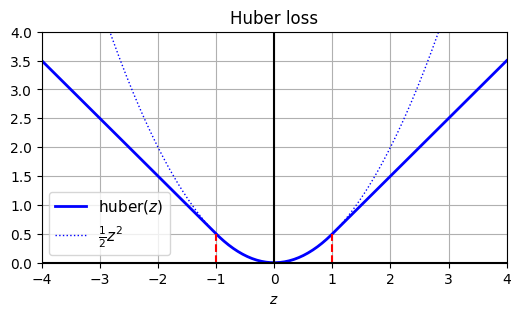

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=11)
plt.title("Huber loss", fontsize=12)
plt.show()

이제 이 후버 손실 함수를 사용하여 케라스 모델의 메서드를 호출하고 모델을 훈련한다.

이를 위해서 캘리포니아 주택 데이터셋을 사용한다. 먼저 이 데이터셋을 로드한 다음에 훈련 세트, 검증 세트, 테스트 세트로 나누고, 마지막으로 스케일을 변경한다.

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.5549 - mae: 0.9060 - val_loss: 0.3742 - val_mae: 0.6590
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2127 - mae: 0.5002 - val_loss: 0.3195 - val_mae: 0.5991


케라스는 모델이 훈련하는 동안 **배치마다 `huber_fn()` 함수를 호출하여 손실을 계산**하고, 이를 사용하여 **경사 하강법을 수행**한다.

또한 **에포크 시작부터 전체 손실을 기록**하여 **평균 손실을 출력**한다.


### 12.3.2 사용자 정의 요소를 가진 모델을 저장하고 로드하기
케라스가 함수의 이름을 저장하므로 `save()` 메서드를 사용하여 사용자 정의 손실 함수를 사용하는 모델을 아무런 이상없이 저장할 수 있다.

`load_model()` 메서드로 저장된 모델을 로드할 때는 **함수의 이름과 실제 함수를 매핑한 딕셔너리를 전달**해야 한다.

In [ ]:
model.save("my_model_with_a_custom_loss.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2021 - mae: 0.4864 - val_loss: 0.2730 - val_mae: 0.5560
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1942 - mae: 0.4768 - val_loss: 0.2033 - val_mae: 0.4794


앞에서 구현한 함수는 -1과 1 사이의 오차를 작은 것으로 간주한다.

만약 다른 기준이 필요한 경우에는 매개변수를 받을 수 있는 함수를 만들어야 한다.

아래의 `create_huber()`는 `huber_fn()`를 이용하여 threshold를 1로 하는 함수를 만든 것이다.

In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2126 - mae: 0.4725 - val_loss: 0.2063 - val_mae: 0.4666
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2089 - mae: 0.4700 - val_loss: 0.2372 - val_mae: 0.4738


안타깝게도 이 모델을 저장할 때 threshold 값은 저장되지 않는다.

따라서 모델을 로드할 때는 threshold 값을 지정해야 한다. 이때 새로 정의한 함수 이름이 아니라 저장한 케라스 모델에서 사용했던 함수 이름인 `huber_fn`를 사용해야 한다.

In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2052 - mae: 0.4655 - val_loss: 0.2217 - val_mae: 0.4607
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2049 - mae: 0.4636 - val_loss: 0.1917 - val_mae: 0.4510


이 문제는 `keras.losses.Loss` 클래스를 상속하고, `get_config()` 메서드를 구현하여 해결할 수 있다.

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


        def __init__(self, threshold=1.0, **kwargs):
            self.threshold = threshold
            super().__init__(**kwargs)`
 - 생성자는 기본적인 하이퍼파라미터를 **kwargs로 받은 매개변수 값을 부모 클래스의 생성자에게 전달한다.
 - 손실 함수의 name과 개별 샘플의 손실을 모으기 위해 사용할 reduction 알고리즘이다. 기본값은 "sum_over_batch_size"로 샘플 손실에 가중치를 곱하여 더하고, 배치 크기로 나눈다. 만약 샘플 가중치가 없다면 1.0으로 간주한다.
 - 다른 값으로는 "sum"과 "none"이 있다.


        def call(self, y_true, y_pred):
            error = y_true - y_pred
            is_small_error = tf.abs(error) < self.threshold
            squared_loss = tf.square(error) / 2
            linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
            return tf.where(is_small_error, squared_loss, linear_loss)
 - `call()` 메서드는 레이블과 예측을 받고, 모든 샘플의 손실을 계산하여 반환한다.


        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "threshold": self.threshold}
 - `get_config()` 메서드는 하이퍼파라미터 이름과 같이 매핑된 딕셔너리를 반환한다.
 - 먼저 부모 클래스의 `get_config()` 메서드를 호출하고, 다음으로 반환된 딕셔너리에 새로운 하이퍼파라미터를 추가한다.

이제 모델을 컴파일할 때 이 클래스의 인스턴스를 사용할 수 있다.


In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.8395 - mae: 0.9856 - val_loss: 0.5717 - val_mae: 0.6831
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2560 - mae: 0.5218 - val_loss: 0.4368 - val_mae: 0.5954


이 모델을 저장할 때는 임계값도 함께 저장된다. 따라서 모델을 로드할 때 딕셔너리로 클래스 이름과 클래스 자체를 매핑해주어야 한다.

모델을 저장할 때 케라스는 손실 객체의 `get_config()` 메서드를 호출하여 반환된 설정을 HDF5 파일에 JSON 형태로 저장한다.

모델을 로드하면 `HuberLoss` 클래스의 `from_config()` 클래스 메서드를 호출한다. 이 메서드는 기본 손실 클래스 `Loss`에 구현되어 있으며, 생성자에게 **config 매개변수를 전달하여 클래스의 인스턴스를 만든다.

In [ ]:
model.save("my_model_with_a_custom_loss_class.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

### 12.3.3 활성화 함수, 초기화, 규제, 제한을 커스터마이징하기
**손실, 규제, 제한, 초기화, 지표, 활성화 함수, 층, 모델**과 같은 대부분의 **케라스 기능은 유사한 방법으로 커스터마이징** 할 수 있다. 대부분의 경우가 적절한 입력과 출력을 가진 간단한 함수를 작성하면 된다.

**지표**의 경우는 조금 다르므로 다음에 다시 살펴보기로 한다.

이 아래의 코드들은 활성화 함수, 초기화, 규제, 제한을 각각 커스터마이징하는 함수를 정의한 것이다.

#### 사용자 정의 활성화 함수
`keras.activations.softplus()` 또는 `tf.nn.softplus()`와 동일

In [ ]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

#### 사용자 정의 글로럿 초기화
`keras.initializers.glorot_normal()`과 동일

In [ ]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

#### 사용자 정의 $l_1$ 규제
`keras.regularizers.l1(0.01)`과 동일

In [ ]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

#### 양수인 가중치만 남기는 사용자 정의 제한
`keras.constraints.nonneg()`나 `tf.nn.relu()`와 동일

In [ ]:
def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

위에서 볼 수 있듯이 함수의 매개변수는 사용자가 정의하려는 함수의 종류에 따라 다르다.

만들어진 사용자 정의 함수는 보통의 함수와 동일하게 사용할 수 있다.

예를 들어 다음과 같은 모델을 구현한다고 가정한다.

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

이 모델의 **활성화 함수** `my_softplus()`는 `**Dense` 층의 출력에 적용**되고, **다음 층에 그 결과가 전달**된다.

**층의 가중치**는 초기화 함수 `my_glorot_initializer()`에서 **반환된 값으로 초기화**된다.

훈련 스텝마다 가중치가 규제 함수 `my_l1_regularizer()`에 전달되어 **규제 손실을 계산**하고, 전체 손실에 추가되어 **훈련을 위한 최종 손실**을 만든다.

마지막으로 제한 함수 `my_positive_weights()`가 훈련 스텝마다 호출되어 **층의 가중치를 제한한 가중치 값**으로 바꾼다.

함수가 **모델과 함께 저장해야 할 하이퍼파라미터**를 가지고 있다면 `keras.regularizers.Regularizer, keras.constraints.Constraint, keras.initializers.Initializer, keras.layers.Layer`과 같이 적절한 클래스를 상속한다.

사용자 정의로 클래스를 커스터마이징할 때, **손실, 활성화 함수를 포함하여 층, 모델**의 경우에는 **`call()`** 메서드를 구현해야 한다.

반면 **규제, 초기화, 제한**의 경우에는 **`__call__()`** 메서드를 구현해야 한다.

다음의 코드는 사용자 정의 손실을 만들었던 것처럼 `factor` 하이퍼파라미터를 저장하는 $l_1$ 규제를 위한 간단한 클래스의 예시이다.

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

### 12.3.4 사용자 정의 지표
손실과 지표는 개념적으로는 비슷하다.

크로스 엔트로피 같은 **손실**은 **모델을 훈련하기 위해 사용**하므로, 적어도 평가할 영역은 미분이 가능해야 하고 그래디언트가 모든 곳에서 0이 아니어야 한다. 사람이 쉽게 이해할 수 없어도 무방하다.

반면 정확도 같은 **지표**는 **모델을 평가할 때 사용**한다. 지표는 사람이 이해하기 훨씬 쉬워야 한다. 또한 미분이 불가능하거나 모든 곳에서 그래디언트가 0이어도 괜찮다.

대부분의 경우 사용자 지표 함수를 만드는 것은 사용자 손실 함수를 만드는 것과 동일하다.

앞에서 만든 후버 손실 함수를 지표로 사용해도 모델은 잘 작동한다. 모델을 저장할 때도 동일하게 함수의 이름 'huber_fn'만 저장된다.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal", input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 2.3756 - huber_fn: 0.9824
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6533 - huber_fn: 0.2614


만약에 **손실과 지표에 같은 함수를 사용**하면 **앞과 다른 결과**가 나올 수 있다. 이는 일반적으로 부동 소수점 정밀도 오차 때문이다. 수학 식이 동일하더라도 **연산은 동일한 순서대로 실행되지 않으므로,** 이로 인해 작은 차이가 발생한다. 또한 샘플 가중치를 사용하면 정밀도보다 더 큰 오차가 생긴다.

에포크에서 **손실**은 지금까지 본 **모든 배치 손실의 평균**이다. **각 배치 손실**은 **가중치가 적용된 샘플 손실의 합을 배치 크기로 나눈 것**이다. 샘플 가중치의 합으로 나눈 것이 아니므로, 따라서 배치 손실은 손실의 가중 평균이 아니다.

에포크에서 **지표**는 **가중치가 적용된 샘플 손실의 합을 지금까지 본 모든 샘플 가중치의 합으로 나눈 것**이다. 즉 **모든 샘플 손실의 가중 평균**으로, 따라서 위와 같지 않다.

수학적으로 말하면 손실 = 지표 * 샘플 가중치의 평균 (+ 약간의 부동 소수점 정밀도 오차)이다.

아래의 코드와 같이 손실과 지표에 같은 함수를 사용한 경우 위의 결과와 손실인 `loss`, 지표인 `huber_fn`가 모두 다르게 나타난다.

또한 지표 `huber_fn`에 샘플 가중치의 평균을 곱하면 손실 `loss`과 거의 유사한 것을 확인할 수 있따.

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.1225 - huber_fn: 0.2423
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1158 - huber_fn: 0.2278


In [ ]:
# 손실 = 지표 * 샘플 가중치의 평균 (+ 약간의 부동 소수점 정밀도 오차)
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.1225268542766571, 0.12058312909770401)

케라스의 **`metrics.Precision()`** 클래스는 **진짜 양성 개수와 거짓 양성 개수를 기록**하고, 필요할 때 **정밀도를 계산**할 수 있도록 하는 객체이다.

아래의 예는 `Precision` 클래스 객체를 만들고, 이를 함수처럼 사용하여 첫번째 배치와 두번째 배치의 레이블과 예측을 각각 매개변수로 전달한 것이다.

첫번째 배치를 처리한 후의 정밀도는 80%이고, 두번째 배치를 처리한 후의 정밀도는 50%이다.

정밀도가 각각의 **배치마다 점진적으로 업데이트**되기 때문에, 이를 **스트리밍 지**표 또는 상태가 있는 지표라고 한다.

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

이 지점에서 **`result()`** 메서드를 호출하면 **현재 지표값**을 얻을 수 있다.

또한 `Precision` 클래스 객체에 **`variables`** 속성을 사용하여 **진짜 양성과 거짓 양성을 기록한 변수를 확인**할 수도 있으며, **`result_states()`** 메서드를 사용하여 **이 변수를 초기화**할 수도 있다.

In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states() # 두 변수가 0으로 리셋된다.

이런 스트리밍 지표를 만들고 싶다면 `keras.metrics.Metric` 클래스를 상속한다.

아래의 코드는 전체 후버 손실과 지금까지 처리한 샘플 수를 기록하는 클래스를 구현하는 것이다. 이 클래스에 결과값을 요청하면 평균 후버 손실이 반환된다.

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리 (예를 들면, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

- 생성자는 `add_weight()` 메서드를 사용하여 여러 배치에 걸쳐 지표의 상태를 기록하기 위한 변수를 만든다. 이 예에서는 후버 손실의 합과 지금까지 처리한 샘플의 수를 기록한다.
- `update_state()` 메서드는 이 클래스를 함수처럼 사용할 때 호출된다. 배치의 레이블과 예측을 바탕으로 변수를 업데이트한다.
- `result()` 메서드는 최종 결과를 계산하고 반환한다. 이 예에서는 모든 샘플에 대한 평균 후버 손실값이다.
- `get_config()` 메서드를 구현하여 threshold 변수를 모델과 함께 저장한다.

### 12.3.5 사용자 정의 층
가끔 **텐서플로에는 없는 특이한 층을 가진 네트워크를 만들어야 할 때**가 있다. 이런 경우에는 **사용자 정의 층**을 만든다.

동일한 층 블럭이 여러 번 반복되는 네트워크를 만들 경우 각각의 층 블럭을 하나의 층으로 다루는 것이 편리하다. 예를 들어 모델이 층 A,B,C,A,B,C,A,B,C 순서대로 구성되어 있다면, A,B,C를 사용자 정의 층 D로 정의하고 D,D,D로 구성된 모델을 만들 수 있다.

먼저 `keras.layers.Flatten`이나 `keras.layers.ReLU`와 같은 층은 가중치가 없다. **가중치가 필요 없는 사용자 정의 층을 만들기** 위한 가장 간단한 방법은 **파이썬 함수를 만든 후에 `keras.layers.Lambda` 층으로 감싸는 것**이다.

예를 들면 입력에 지수 함수를 적용하는 층을 만들 수 있다.

이 사용자 정의 층을 **시퀀셜 API나 함수형 API, 서브클래싱 API**에서 **보통의 층과 동일하게 사용**할 수 있다.

또는 **활성화 함수로 사용**할 수도 있다. `activation=tf.exp, activation=keras.activations.exponential, activation="exponential"`을 사용하면 된다.

지수 함수는 이따금 회귀 모델에서 예측값의 스케일이 매우 다를 때 출력층에 사용된다.


In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

상태가 있는 층, 즉 가중치를 가진 층을 만들기 위해서는 `keras.layers.Layer`를 상속해야 한다.

예를 들어 다음의 클래스는 `Dense` 층의 간소화 버전을 구현한 것이다.



In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

만약에 **여러 가지 입력을 받는 층**을 만드려면 `call()` 메서드에 **모든 입력이 포함된 튜플을 매개변수 값으로 전달**해야 한다. 비슷하게 `compute_output_shape()` 메서드의 매개변수도 **각 입력의 배치 크기를 담은 튜플**이어야 한다.

**여러 개의 출력을 가진 층**을 만드려면 `call()` 메서드가 **출력의 리스트를 반환**해야 한다. `compute_output_shape()` 메서드는 **출력마다 하나씩 배치 출력 크기의 리스트를 반환**해야 한다.

예를 들어 아래의 코드는 2개의 입력과 3개의 출력을 만드는 층을 구현하는 클래스이다.

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # 사용자 정의 층 디버깅
        return [X1 + X2, X1 * X2]

    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b2]

이제 이 사용자 정의 층은 다음처럼 함수형 API를 사용해 호출할 수 있다.

하지만 함수형 API와 서브클래싱 API에만 사용할 수 있으며, 하나의 입력과 하나의 출력을 가진 층만 사용하는 시퀀셜 API에는 사용할 수 없다.

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


**훈련과 테스트에서 다르게 동작**하는 층이 필요하다면 `call()` 메서드에 **`training`** 매개변수를 추가하여 **훈련인지 테스트인지 결정**해야 한다.

예를 들어 아래의 클래스는 **훈련하는 동안 가우스 잡음을 추가**하고, 테스트 시에는 아무것도 하지 않는 층을 만들어 본 것이다.

케라스에는 이와 동일한 작업을 하는 `keras.layers.GaussianNoise` 층이 있다.

In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

### 12.3.6 사용자 정의 모델
이미 앞에서 어떻게 사용자 정의 모델 클래스를 만드는지 알아보았다.

방법은 **`keras.Model` 클래스를 상속**하여 **생성자에서 층과 변수**를 만들고, **모델이 해야할 작업을 `call()` 메서드에 구현**한다.

아래의 그림은 스킵 연결이 있는 사용자 정의 잔차 블록 층을 가진 모델이다. 이와 같은 모델을 만들어야 한다고 가정한다.

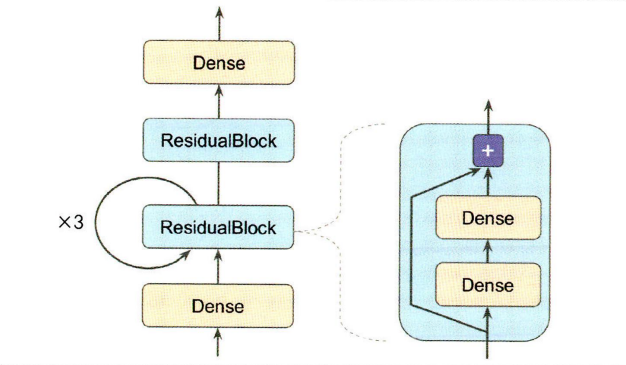

입력이 첫번째 완전 연결 층을 통과하여 2개의 완전 연결 층과 스킵 연결로 구성된 잔차 블록으로 전달된다. 그 다음 동일한 잔차 블록에서 3번 더 통과시킨다.

두번째 잔차 블록을 지나고 마지막 출력이 완전 연결된 출력 층에 전달된다.

위의 모델을 구현하려면 동일한 블록을 여러 개 만들어야 하므로 먼저 `ResidualBlock` 층을 만든다. 이렇게 층을 따로 만들면 다른 모델에도 재사용할 수 있다.

이 층은 다른 층을 포함하고 있으므로 조금 특별하다. 케라스가 알아서 추적해야 할 객체가 담긴 `hidden` 속성을 감지하고, 필요한 변수를 자동으로 이 층의 변수 리스트에 추가한다.

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

그 다음으로 서브클래싱 API를 사용하여 이 모델을 정의한다.

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

생성자에서 층을 만들고, `call()` 메서드에서 이를 사용한다.

이 모델을 다른 일반 모델처럼 컴파일, 평가, 예측에 사용할 수 있다.

`save()` 메서드를 사용하여 모델을 저장하고 `keras.models.load_model()` 함수를 사용하여 저장된 모델을 로드하고 싶다면 `ResidualBlock` 클래스와 `ResidualRegressor` 클래스에 모두 `get_config()` 메서드를 구현해야 한다.

또한 `save_weights(), load_weights()` 메서드를 사용해서 가중치를 저장하고 로드할 수 있다.

**`Model` 클래스는 `Layer` 클래스의 서브클래스**이므로 **모델을 층처럼 정의**할 수 있다.

추가적으로 모델은 `compile(), fit(), evaluate(), predict()` 메서드와 같은 기능을 가진다. 또한 `get_layers(), save()` 메서드도 있다.

모델이 층보다 더 많은 기능을 제공하지만, 모든 층을 모델처럼 정의할 수는 없다. 기술적으로는 가능하지만 일반적으로 모델의 층과 같은 모델 안의 내부 구성 요소를 훈련 대상 객체인 모델과 구분하는 것이 당연하기 때문이다.

**모델의 층과 같은 내부 구성 요소**에는 **`Layer`** 클래스를 상속해야 하고, **모델 객체**에는 **`Model`** 클래스를 상속해야 한다.

### 12.3.7 모델 구성 요소에 기반한 손실과 지표
앞서 정의한 사용자 손실과 지표는 모두 레이블과 예측, 선택적으로 샘플 가중치를 기반으로 한다.

그러나 은닉층의 가중치나 활성화 함수 등과 같이 **모델의 구성 요소에 기반한 손실**을 정의해야 할 때가 있다. 이러한 손실은 **규제나 모델의 내부 상황을 모니터링할 때 유용**하다.

모델 구성 요소에 기반한 손실을 정의하고 계산하여 `add_loss()` 메서드에 그 결과를 전달한다.

예를 들어 5개의 은닉층과 출력층으로 구성된 회귀용 MLP 모델을 만든다. 이 모델은 **맨 위의 은닉층에 보조 출력**을 가지며, 이 **보조 출력에 연결된 손실**을 **재구성 손실**이라고 한다. 즉 재구성과 입력 사이의 평균 제곱 오차이다.

재구성 손실을 주 손실에 더하여 회귀 작업에 직접적으로 도움이 되지 않은 정보일지라도 모델이 은닉층을 통과하면서 가능한 많은 정보를 유지하도록 유도한다. 이러한 손실이 규제 손실처럼 동작하여 가끔 일반화 성능을 향상시킨다.

다음은 사용자 정의 재구성 손실을 갖는 모델을 만드는 코드이다.

In [ ]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))

        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

생성자가 5개의 은닉층과 1개의 출력층으로 구성된 심층 신경망을 만들고, `keras.metrics.Mean()` 메서드로 측정 지표를 만든다.

`bulid()` 메서드에서 완전 연결 층을 하나 더 추가하여 모델의 입력을 재구성하는데 사용한다. 이 완전 연결 층의 유닛 개수는 입력 개수와 같아야 한다.

`call()` 메서드에서 입력이 5개의 은닉층을 모두 통과하고, 결과값을 재구성 층에 전달하여 재구성을 만든다. 재구성과 입력 사이의 평균 제곱 오차를 계산한다. 이때 훈련에서만 사용해야 하기 때문에 `call(`) 메서드에 `training` 매개변수를 추가한다. `training=True`이면 reconstruction_mean를 업데이트하고 `self.add_metric()`를 호출한다.

사용자 정의 지표의 결과값이 지표 객체의 출력이라면 모델의 `add_metric()` 메서드를 호출하여 모델에 이 지표를 추가한다.

`call()` 메서드의 마지막에서 은닉층의 출력을 출력층에 전달하여 얻은 출력값을 반환한다.


In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=3)
y_pred = model.predict(X_test_scaled)

Epoch 1/3
363/363 [==============================] - 5s 4ms/step - loss: 0.7063 - reconstruction_error: 0.0000e+00
Epoch 2/3
363/363 [==============================] - 1s 3ms/step - loss: 0.4112 - reconstruction_error: 0.0000e+00
Epoch 3/3
162/162 [==============================] - 0s 1ms/step


### 12.3.8 자동 미분을 사용하여 그래디언트 계산하기
자동 미분을 사용하여 그래디언트를 자동으로 계산하는 방법을 이해하기 위해서 간단한 함수의 예를 살펴본다.

어떤 함수 $3\cdot w1^2+2\cdot w1\cdot w2$에 대하여 w1에 대한 이 함수의 도함수가 $6\cdot w1+2\cdot w2$이라는 것을 구할 수 있다. w2에 대한 도함수는 $2\cdot w1$이다. 예를 들어 포인트 (w1,w2)=(5,3)에서 도함 수 값은 각각 36,10으므로, 따라서 이 포인트의 그래디언트 벡터는 (36,10)이다.

신경망은 보통 수만 개의 파라미터를 가진 매우 복잡한 함수로, 손으로 직접 도함수를 계산하는 것은 거의 불가능한 작업이다. 이에 대한 한가지 대안으로 각 파라미터가 바뀔 때마다 함수의 출력이 얼마나 변하는지 측정하여 도함수의 근삿값을 계산할 수 있다.

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [ ]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [ ]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

이 방법은 잘 작동하고 구현하기도 쉽지만, 근삿값이며 무엇보다도 **파라미터마다 적어도 한번씩 함수를 호출**해야 한다.

따라서 이 방법은 대규모 신경망에서는 적용하기 어렵다. 대신 **자동 미분**을 사용할 수 있다.

텐서플로에서는 아주 쉽게 계산할 수 있다. 먼저 두 변수 w1과 w2를 정의하고 **`tf.GradientTape`** 블럭을 만들어서 이 **변수와 관련된 모든 연산을 자동으로 기록**한다.

마지막으로 이 테이프에 **`gradient`**를 사용하여 두 변수 [w1,w2]에 대한 z의 **그래디언트를 요청**한다.

부동소수점 오차에 따라 정밀도가 제한되기는 하지만, 위의 도함수로 구한 결과와 동일하므로 정확하다. 또한 변수가 얼마나 많든지 `gradient()` 메서드는 기록된 계산을 한번만에 통과하므로 매우 효율적인 방법이다.

In [ ]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

In [ ]:
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

기본적으로 테이프는 **변수가 포함된 연산만을 기록**한다. 만약 **변수가 아닌 다른 객체**에 대한 z의 그래디언트를 계산하려면 **None이 반환**된다.

하지만 `watch()` 메서드를 사용하면 필요한 어떤 텐서라도 감시하여 **관련된 모든 연산을 기록하도록 강제**할 수 있다. 그 다음에는 포함되지 않은 변수에 대해서도 그래디언트를 계산할 수 있다.

예를 들어 입력이 작을 때 변동 폭이 큰 활성화 함수에 대한 규제 손실을 구현하는 경우, 입력은 변수가 아니므로 테이프에 기록을 명시적으로 알려주어야 하므로 이때 이 기능을 사용할 수 있다.

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

In [ ]:
gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

In [ ]:
gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

대부분의 경우 그래디언트 테이프는 **모델 파라미터인 여러 값에 대한 손실 같은 하나의 값의 그래디언트를 계산**하는데 사용된다. 이러한 경우에는 **후진 모드 자동 미분**이 적합하다. 한 번의 정방향 계산과 역방향 계산으로 모든 그래디언트를 동시에 계산할 수 있기 때문이다.

만약 여러 손실이 포함된 벡터의 그래디언트를 계산하면 텐서플로는 벡터의 합의 그래디언트를 계산할 것이다.

그 대신 **개별 그래디언트를 계산**하고 싶다면 테이프의 **`jacobian()`** 메서드를 호출해야 한다. 이 메서드는 벡터에 있는 각 손실마다 후진 자동 미분을 수행한다. 또한 이계도함수도 계산할 수 있다.

In [ ]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [ ]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

어떤 경우에는 **신경망의 일부분에 그래디언트가 역전파되지 않도록 막을 필요**가 있다. 이렇게 하기 위해서는 **`tf.stop_gradient()`** 함수를 사용해야 한다.

이 함수는 정방향 계산을 할 때는 입력을 반환하지만, 역전파 시에는 그래디언트를 전파하지 않고 상수처럼 동작한다.

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

가끔 그래디언트를 계산할 때 수치적인 이슈가 발생하기도 한다. 예를 들어 큰 입력에 대한 `my_softplus()` 함수의 그래디언트를 계산하면 NaN이 반환된다.

이는 자동 미분을 사용하여 이 함수의 그래디언트를 계산하는 것이 수치적으로 불안정하기 때문이다. 즉 부동소수점 정밀도 오류로 인하여 자동 미분이 무한 나누기 무한을 계산하게 되고, 따라서 NaN이 반환된다.

다행히 수치적으로 안전한 소프트플러스의 도함수 $1/(1+1/\exp(x))$를 해석적으로 구할 수 있다. 그 다음 @tf.custom_gradient 데코 레이터를 사용하고 일반 출력과 도함수를 계산하는 함수를 반환하여 텐서플로가 `my_softplus()` 함수의 그래디언트를 계산할 때 안전한 함수를 사용하도록 만들 수 있다.

이제 큰 입력 값에서도 `my_better_softplus()` 함수의 그래디언트를 올바르게 계산할 수 있다. 하지만 여전히 지수함수이기 때문에 폭주하므로, `tf.where()`를 사용하여 값이 클 때 입력을 그대로 반환하도록 하여 해결하면 된다.

In [ ]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [ ]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [ ]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [ ]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

### 12.3.9 사용자 정의 훈련 반복
드물게 `fit()` 메서드의 유연성이 원하는 만큼 충분하지 않을 수 있다.

만약 어떤 모델이 2개의 다른 옵티마이저를 사용한다고 가정한다. `fit()` 메서드는 하나의 옵티마이저만 사용하므로 이 모델을 구현하려면 훈련 반복을 직접 구현해야 한다.

또는 모델이 의도한 대로 잘 작동하는지 확인하기 위해 사용자 정의 훈련 반복을 사용할 수도 있다.

사용자 훈련 반복을 사용하면 분명하고 정확하게 하여 안전하지만, 길고 버그가 발생하기 쉬우며 유지 보수하기 어려운 코드가 만들어진다는 단점이 있다.

먼저 이를 위해 간단한 모델을 만든다. 훈련 반복을 직접 다루기 때문에 컴파일할 필요가 없다.

In [ ]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal", kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

그 다음 훈련 세트에서 샘플 배치를 랜덤하게 추출하는 작은 함수를 만든다.

또한 현재 스텝 수, 전체 스텝 횟수, 에포크 시작부터의 평균 손실, 그 외의 다른 지표를 포함하여 훈련 상태를 출력하는 함수도 만든다.
- {:.4f}는 소수점 뒤에 자릿수가 4개인 실수를 의미한다.
- end와 함께 /r을 사용하면 상태 막대가 동일한 줄에 출력된다.

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)

이 함수를 실제로 적용해보기 위해 먼저 몇 개의 하이퍼파라미터를 정의하고, 옵티마이저는 Nadam, 손실 함수와 지표로는 MAE를 선택한다.

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [ ]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 - mean: 1.3735 - mean_absolute_error: 0.5805
Epoch 2/5
11610/11610 - mean: 0.6578 - mean_absolute_error: 0.5227
Epoch 3/5
11610/11610 - mean: 0.6485 - mean_absolute_error: 0.5189
Epoch 4/5
11610/11610 - mean: 0.6409 - mean_absolute_error: 0.5140
Epoch 5/5
11610/11610 - mean: 0.6378 - mean_absolute_error: 0.5147


위의 코드를 하나씩 살펴본다.
- 2개의 반복문을 중첩한다. 하나는 에포크를 위한 것이고, 다른 하나는 에포크 안의 배치를 위한 것이다.
- 그 다음 훈련 세트에서 배치를 랜덤하게 샘플링한다.
- `tf.GradientTape()` 블럭 안에서 배치 하나를 위한 예측을 만들고 손실을 계산한다. 이 손실은 주 손실에 다른 손실을 더한 것이다. `tf.reduce_mean()` 함수를 사용하여 배치에 대한 평균을 계산한다. 규제 손실은 하나의 스칼라 값이므로 `tf.add_n()` 함수를 사용하여 손실을 모두 더한다.
- 테이프를 사용하여 훈련 가능한 각 변수에 대한 손실의 그래디언트를 계산한다. 이를 옵티마이저에 적용하여 경사 하강법을 수행한다.
- 현재 에포크에 대한 평균 손실과 지표를 업데이트하고 상태 막대를 출력한다.
- 매 에포크의 끝에서 상태 막대를 다시 출력하여 완료를 나타내고 줄바꿈을 수행한다. 마지막으로 평균 손실과 지표값을 초기화한다.

## 12.4 텐서플로 함수와 그래프
텐서플로 1에서 그래프는 텐서플로 API의 핵심이므로 피할 수가 없었지만, 텐서플로 2에서는 그래프가 이전만큼 핵심적이지 않고 사용하기도 매우 쉽다.

간단한 예로 입력의 세제곱을 계산하는 함수를 만들어서 살펴본다. 정수나 실수 같은 파이썬 상수 혹은 텐서를 사용하여 이 함수를 호출할 수 있다.



In [ ]:
def cube(x):
    return x ** 3

In [ ]:
cube(2)

8

In [ ]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

이제 **`tf.function()`**을 사용하여 이 **파이썬 함수를 텐서플로 함수로** 바꾼다.

바뀐 **텐서플로 함수**는 원래의 파이썬 함수처럼 사용할 수 있으며, 동일하지만 **텐서인 결과를 반환**한다.

만약 **원본 파이썬 함수가 필요**하다면 텐서플로 함수의 **`python_function()`** 속성으로 참조할 수 있다.

In [ ]:
tf_cube = tf.function(cube)
tf_cube

In [ ]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
tf_cube.python_function(2)

8

내부적으로 `tf.function()`은 `cube()` 함수에서 수행되는 계산을 분석하고 동일한 작업을 수행하는 계산 그래프를 생성한다.

실제로는 다른 방법인 `@tf.function` 데코레이터가 더 널리 사용된다.

In [ ]:
@tf.function
def tf_cube(x):
    return x ** 3

텐서플로는 **사용하지 않는 노드를 제거**하고 **표현을 단순화**하는 등의 방식으로 **계산 그래프를 최적화**한다. 최적화된 그래프가 준비되면 텐서플로는 적절한 순서에 맞춰 그래프 내의 연산을 효율적으로 실행한다.

따라서 일반적으로 **텐서플로 함수는 원본 파이썬 함수보다 훨씬 빠르게 실행**되며, 특히 복잡한 연산을 수행할 때 더 두드러진다. 파이썬 함수를 빠르게 실행하려면 텐서플로 함수로 변환하면 된다.

또한 사용자 정의 손실, 지표, 층 또는 다른 어떤 사용자 정의 함수를 작성하고 이를 **케라스 모델에 사용**할 때, **케라스는 이 파이썬 함수를 자동으로 텐서플로 함수로 변환**한다. 즉 `tf.function()`을 사용할 필요가 없다.

만약 케라스가 파이썬 함수를 **텐서플로 함수로 바꾸지 못하게 하려면** 사용자 정의 층이나 모델을 만들 때 **`dynamic=True`**로 지정한다. 또는 모델의 **`complie()`** 메서드를 호출할 때 **`run_eagerly=True`**로 지정할 수 있다.

In [ ]:
# 사용자 손실 함수
def my_mse(y_true, y_pred):
    print("my_mse() 손실 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
# 사용자 지표 함수
def my_mae(y_true, y_pred):
    print("my_mae() 지표 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [ ]:
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model = MyModel(dynamic=True)
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

기본적으로 텐서플로 함수는 호출에 사용되는 **입력 크기와 데이터 타입**에 맞춰서 매번 **새로운 그래프를 생성**한다.

예를 들어 `tf_cube(tf.constant(10))`와 같이 호출하면 [ ] 크기의 int32 텐서에 맞는 그래프가 생성된다. 그 다음 ``tf_cube(tf.constant(20))`를 호출하면 동일한 그래프가 **재사용**된다.

하지만 `tf_cube(tf.constant([10,20]))`를 호출하면 [2] 크기의 int32 텐서에 맞는 새로운 그래프가 생성될 것이다.

텐서플로 함수는 이런 식으로 **다양한 매개변수 타입과 크기의 다형성을 처리**한다. 이는 **매개변수 값으로 텐서를 사용했을 때만** 해당된다.

만약 파이썬 값을 텐서플로 함수에 전달하면 고유한 값마다 새로운 그래프가 생성된다. 예를 들어 `tf_cube(10)`과 `tf_cube(20)`는 2개의 그래프를 만든다.

### 12.4.1 오토그래프와 트레이싱
**텐서플로가 그래프를 생성하는 과정**은 다음과 같다.

먼저 **파이썬 함수의 소스 코드를 분석**하여 for문, while문, if문은 물론, break, continue, return과 같은 **제어문을 모두 찾는다.** 이 첫번째 단계를 **오토그래프**라고 한다.

텐서플로 소스코드를 분석하는 이유는 **파이썬이 제어문을 찾을 수 있는 방법을 제공하지 않기 때문**이다. 파이썬에 +와 * 연산을 위한 `__add__(), __mul__()`와 같은 메서드는 있지만, `__while__(), __if__()`와 같은 메서드는 없다.

함수의 코드를 분석한 후, **오토그래프**는 이 함수의 **모든 제어문을 텐서플로 연산으로 바꾼 업그레이드된 버전**을 만든다. 예를 들어 반복문은 `tf.while_loop()`로 바꾸고, if문은 `tf.cond()`로 바꾼다.

아래의 그림은 텐서플로가 오토그래프와 트레이싱을 사용하여 그래프를 생성하는 방법을 나타낸 것이다.

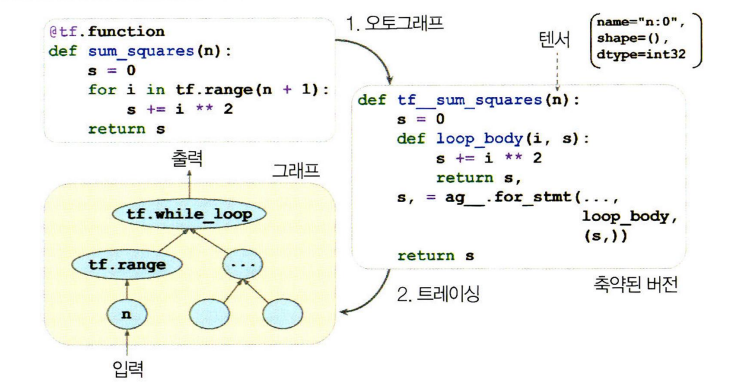

오토그래프는 `sum_squares()` 파이썬 함수의 소스 코드를 분석하고, `tf__sum_squares()` 함수를 생성한다. 이 함수에서 for문은 원래의 반복문 for 안의 코드를 포함한 `loop_body()` 함수로 바뀌었다.

다음으로 **`for_stmt()`** 함수를 호출한다. 이 함수는 **계산 그래프 안에 `tf.while_loop()` 연산을 만들 것**이다.

그 다음에는 **텐서플로가 이렇게 업그레이드된 함수를 호출**한다. 하지만 매개변수 값을 전달하는 대신에 **심볼릭 텐서를 전달**한다. 심볼릭 텐서는 실제 값은 없고, 이름, 데이터 타입, 크기만 가진다.

예를 들어 `sum_squares(tf.constant(10))`를 호출하면 `tf__sum_squares()` 함수는 크기가 [ ]이고 int32 타입의 심볼릭 텐서를 사용하여 호출된다.

이 함수는 **그래프 모드**로 실행될 것이며, 이는 **각 텐서플로 연산이 해당 연산을 나타내고** 텐서를 출력하기 위해 **그래프에 노드를 추가한다**는 의미이다. 텐서플로 연산은 어떤 계산도 수행하지 않으며, 이는 그래프 모드가 기본 모드인 텐서플로 1과 비슷하다.

위의 그림에서는 `tf__sum_squares()` 함수가 심볼릭 텐서를 매개변수로 하여 호출된다. **최종 그래프**는 **트레이싱 과정을 통해 생성**된다. 각 **노드는 연산**을 나타내고, **화살표는 텐서**를 나타낸다.

### 12.4.2 텐서플로 함수 사용 방법
대부분의 경우 텐서플로 연산을 수행하는 파이썬 함수를 텐서플로 함수로 바꾸는 것은 간단하다. **`@tf.function` 데코레이터를 사용**하면 **케라스가 나머지를 알아서 처리**한다.

그러나 몇 가지 지켜야할 규칙이 있다.
1. 넘파이나 표준 라이브러리를 포함해서 **다른 라이브러리를 호출하면 트레이싱 과정에서 실행**될 것이다. **이 호출은 그래프에 포함되지 않는다.** 실제로 **텐서플로 그래프는** 텐서플로 구성 요소인 **텐서, 연산, 변수, 데이터셋 등만 포함**할 수 있다.
 - 트레이싱 과정에서 코드가 실행되는 것을 원하지 않는다면 `np.sum()` 대신에 `tf.reduce_sum()`을, `sorted()` 내장 함수 대신에 `tf.sort()`와 같이 사용해야 한다.
 - 텐서플로에서 지원하지 않는 코드가 부수적인 작업을 하면 함수를 트레이싱할 때만 호출되므로, 텐서플로 함수를 호출할 때 이 코드가 실행되지 않는다.
 - 어떤 임의의 코드를 `tf.py_function()`으로 감쌀 수 있으나, 최적화를 수행할 수 없어서 성능이 저하된다. 또한 파이썬이 가능한 플랫폼에서만 이 그래프가 실행되므로 이식성이 낮아진다.
2. **다른 파이썬 함수나 텐서플로 함수를 호출**할 수 있다. 하지만 텐서플로가 계산 그래프에 있는 이 함수들의 연산을 감지하므로 동일한 규칙을 따른다. 이런 함수들은 `@tf.function` 데코레이터를 적용할 필요가 없다.
3. **함수에서 텐서플로 변수를 만든다**면 **처음 호출될 때만 수행**되어야 하며, 아닌 경우에는 예외가 발생한다. 일반적으로 텐서플로 함수 밖에서 변수를 생성하는 것이 좋다. 변수에 새로운 값을 할당하겨면 = 연산자가 아닌 `assign()` 메서드를 사용해야 한다.
4. **파이썬 함수의 소스 코드는 텐서플로에서 사용 가능**해야 한다. 만약 소스 코드를 사용할 수 없다면 그래프 생성 과정이 실패하거나 일부 기능을 사용할 수 없을 것이다.
5. **텐서플로는 텐서나 데이터셋을 순회하는 for문만을 감지**한다. 따라서 `for i in range(x)`가 아니라 `for i in tf.range(x)`를 사용해야 한다.
6. 성능 면에서는 **반복문보다** 가능한한 **벡터화된 구현을 사용**하는 것이 좋다.